In [1]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import lmfit
import emcee
import corner

saltire_dir = '/home/ADF/sebastdz/Documents/5Software/saltire'
sys.path.insert(0, os.path.abspath(saltire_dir))

import saltire
import radial_vel

In [2]:
#Load some functions for this tutorial (These are not part of saltire)

def time_peri_to_time_tran(t0, P, e, w, sec = False):
    '''
    Converting time of periastron passage to transit time
    
    t0 = (float) Time of periastron passage
    P = (float) Period of orbit (days)
    e = (float) eccentricity
    w = (float) argument of periastron (rads)
    
    returns:
        t_transit = (float) Time of transit (BJD)
        
    Borrowed from 'rad_vel' for illustrative purposes:
    https://radvel.readthedocs.io/en/latest/_modules/radvel/orbit.html
    '''
    
    try:
        if e >= 1:
            return t0
    except ValueError:
        pass


    if sec ==  True:
        f = -np.pi/2 - w
    else:
        f = np.pi/2 - w                                    # true anomaly during transit
    E = 2 * np.arctan(np.tan(f/2) * np.sqrt((1-e)/(1+e)))  # eccentric anomaly 

    t_transit = t0 + P/(2*np.pi) * (E - e*np.sin(E))         # time of transit
    
    return t_transit

# *saltire* - Tutorial 2

### *saltire* can be used to predict cross-correlation function maps.
### This notebook will show how to predict CCF maps for typical HRCCS observation strategies.

In [3]:
data_path   = '.'
output_path = 'tutorial_2'

#define output path
outp = os.path.join(data_path,output_path)
#Check for output folder or create it
if os.path.exists(outp)==False:
    os.makedirs(outp)

# Define planned observations and create model

In [4]:
###### Define model parameters ######

K_start=77.      #Expected semi mayor axis of secondary [km/s]
v_start=32       #Expected systemic (or rest) velocity [km/s]
sum_amp = -2e-4  #Expected depth of CCF (negative for abosorption, positive for emission)
dif_amp = -0.2   #allowed: -1 til 0. Set it close to 0, if no sidelobes are expected, close to -0.5, if clear sidelobes are seen. smaller than -0.5 will not change much, but increase calculation times.
sigmax1 =2.5     #Expected width of Gaussian [km/s]
sigmax2 =8.8     #expected witdh of sidelobes [km/s], has to be larger than sigmax1 (independent from its amplitude).


params = lmfit.Parameters()
params.add('K', value=K_start, min = K_start-5.1,max = K_start+5.1)
params.add('v_sys', value=v_start, min = v_start-10,max = v_start+10)
params.add('height', value=1., min = 1-1e-4,max = 1+1e-4)
params.add('sum_amp', value=sum_amp, min = 0.2*sum_amp ,max = 3.5*sum_amp)
params.add('dif_amp', value=dif_amp, min = 1e-2 ,max = -0.49)
params.add('sigmax1', value=sigmax1, min = 0.5,max = 5)
params.add('sigmax2', value=sigmax2, min = sigmax1,max = 10) # sigmax1,max = 12)

## 1.) Planet observed around superior conjunction (eclipse).

In [5]:
#Specify range of semi-amplitudes of CCF map [km/s]
k_min = 0
k_max = 300
k_step= 2
K_p = np.linspace(k_min,k_max,int(k_max/k_step)+1)

#Specify velocity range of CCF map [km/s]
v_min = 0
v_max = 51
v_step= 1.5
velo = np.linspace(v_min,v_max,int(v_max/v_step)+1)

#Grid of map for fitting
x,y = np.meshgrid(velo,K_p)

In [6]:
###### Define orbit parameters ######

#Orbit parameters for model creation. This allows to use different orbit parameters for each call. 
#If one parameter set has been used, please still provide an array (filled with equal values) 

period = np.ones(len(K_p))*3.46
T0     = np.ones(len(K_p))*2456000.3
ecc    = np.ones(len(K_p))*0.0
omega  = np.ones(len(K_p))*0.5*np.pi
fixpar = np.array([period,T0,ecc,omega])

#Derive times of primary transits and occultation for above orbit.
T_trans = time_peri_to_time_tran(T0[0], period[0], ecc[0], omega[0], sec = False)
T_occ   = time_peri_to_time_tran(T0[0], period[0], ecc[0], omega[0], sec = True)
print(T_trans,T_occ,(T_trans-T_occ))

2456000.3 2455998.57 1.7299999999813735


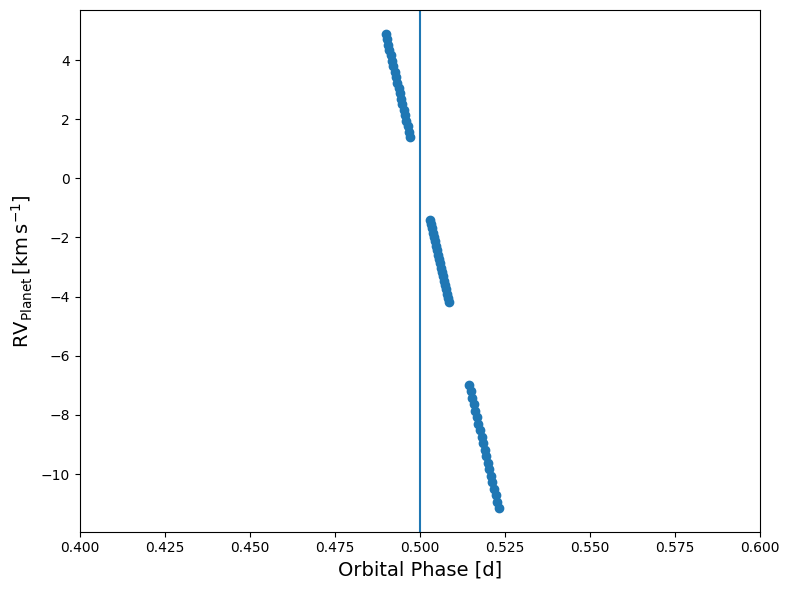

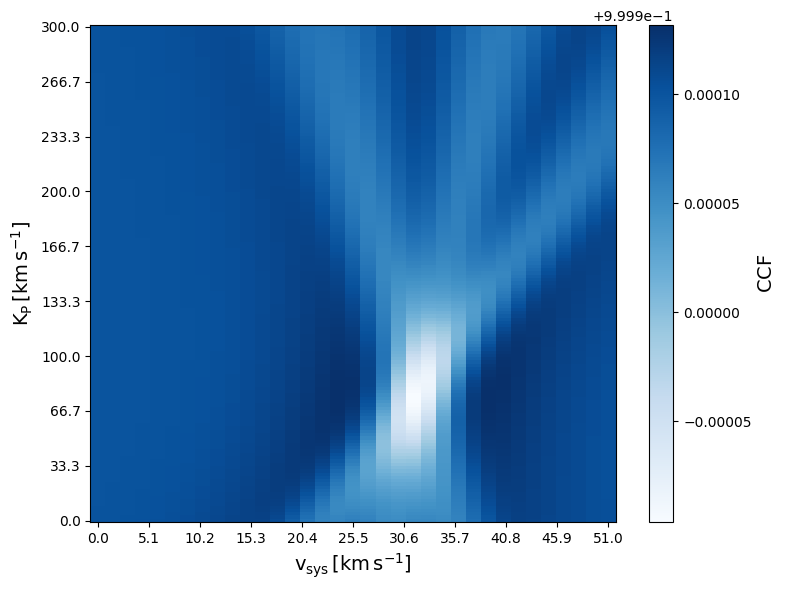

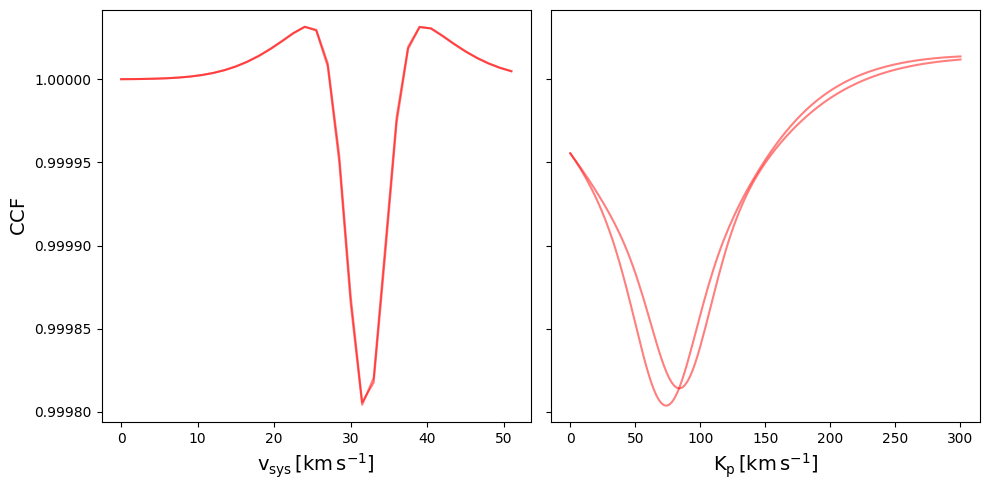

In [7]:
#Create observation times: 20 spectra each for three observation nights around superior conjunction:
time_occ  = (T_occ-T_trans)%period[0]

obstimes2 = np.linspace(T_occ-0.035,T_occ-0.01,20)
obstimes3 = np.linspace(T_occ+0.01,T_occ+0.03,20)
obstimes4 = np.linspace(T_occ+0.05,T_occ+0.08,20)

#Add all nights together
obstimes=np.hstack([obstimes2,obstimes3,obstimes4])
phases  = (obstimes-T_trans)%period[0]/period[0]

#Weighting. ones for now, but typically SNR of each observation. 
weights = np.ones(len(obstimes))

planet=True #To fit the planet or the star. Usually True, if it is the planet or secondary star. If False, the CCF map for the primary star is calculated (Note: The CCF map has to be specifically created for one case).

#pack parameters
obs = [obstimes,weights,planet]

# Visualise orbit
saltire.orbit_plot(obs,fixpar,K_start,T_trans=T_trans,T_occ=T_occ,xlim=(0.4,0.6),
                  file=os.path.join(outp,'01_sup_conj_orbit.png'),save=True,plotting=True)

# Visualise model
model = saltire.fit_residual(params,x, y,obs=obs,fixpar=fixpar.T).reshape(len(K_p),len(velo))#,data=fit_data)
saltire.plot_axis2D(velo,K_p,model,savefig=True,outim=os.path.join(outp,'01_sup_conj_model.png'))


# Plot cuts in both axes, lower and upper to the signal position. 
saltire.cutplot(velo,K_p,
                v_start,
                K_start,
                None,model,file=os.path.join(outp,'01_sup_conj_cut.png'),save=True,plotting=True,margin=1e-5)

## 2.) Planet observed in transit

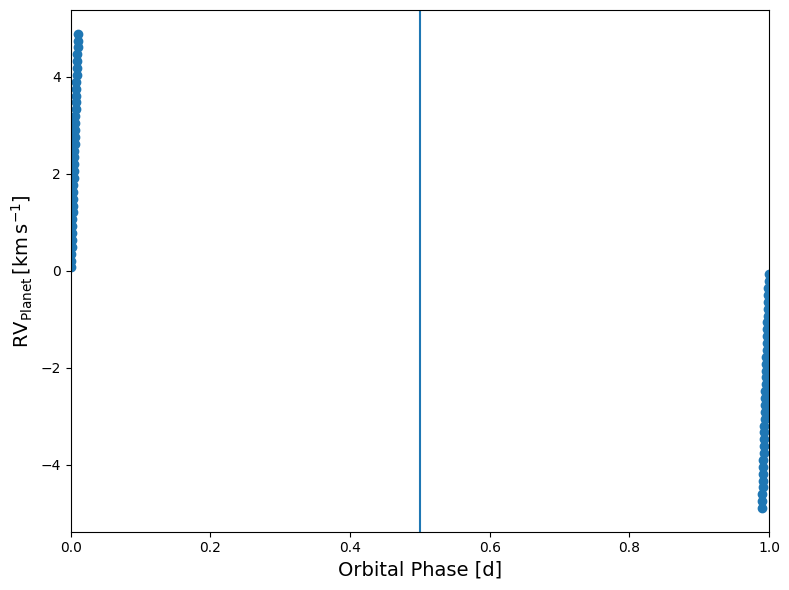

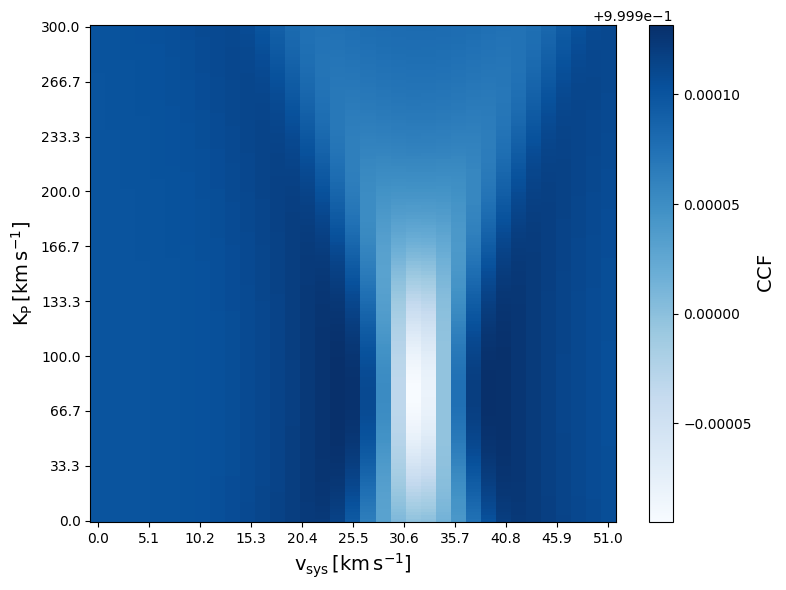

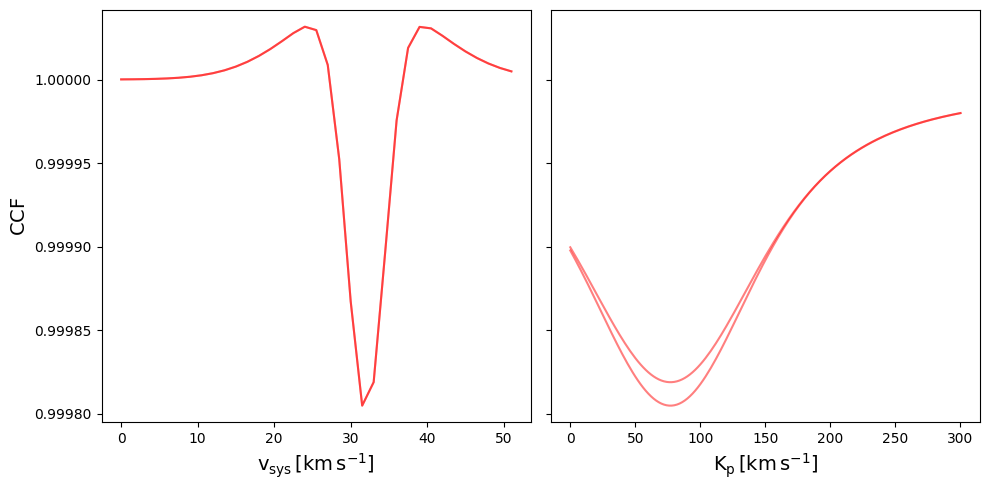

In [8]:
obstimes = np.linspace(T_trans-0.035,T_trans+0.035,70)

phases  = (obstimes-T_trans)%period[0]/period[0]

#Weighting. typically SNR of each observation 
weights = np.ones(len(obstimes))

planet=True #To fit the planet or the star. Ususally True, if it is the planet or secondary star (Note: The CCF map has to be specifically created for one case).
#pack parameters
obs = [obstimes,weights,planet]

# Visualise orbit
saltire.orbit_plot(obs,fixpar,K_start,T_trans=T_trans,T_occ=T_occ,
                  file=os.path.join(outp,'02_transit_orbit.png'),save=True,plotting=True)

# Visualise model
model = saltire.fit_residual(params,x, y,obs=obs,fixpar=fixpar.T).reshape(len(K_p),len(velo))#,data=fit_data)
saltire.plot_axis2D(velo,K_p,model,savefig=True,outim=os.path.join(outp,'02_transit_model.png'))

# Plot cuts in both axes, lower and upper to the signal position. 
saltire.cutplot(velo,K_p,
                v_start,
                K_start,
                None,model,file=os.path.join(outp,'02_transit_cut.png'),save=True,plotting=True,margin=1e-5)

## 3.) Eccentric Binary with differently sampled observations

In [9]:
k_min = 5
k_max = 111
k_step= 2.
K_p = np.linspace(k_min,k_max,int((k_max-k_min)/k_step)+1)

#Specify velocity range of CCF map [km/s]
v_min = 0
v_max = 51
v_step= 1.5
velo = np.linspace(v_min,v_max,int((v_max-v_min)/v_step)+1)

#Grid of map for fitting
x,y = np.meshgrid(velo,K_p)

In [10]:
###### Define orbit parameters ######

#Orbit parameters for model creation. This allows to use different orbit parameters for each call. 
#If one parameter set has been used, please still provide an array (filled with equal values) 

period = np.ones(len(K_p))*5.46
T0     = np.ones(len(K_p))*2456000.3
ecc    = np.ones(len(K_p))*0.
omega  = np.ones(len(K_p))*0.6*np.pi
fixpar = np.array([period,T0,ecc,omega])

#Derive times of primary transits and occultation
T_trans = time_peri_to_time_tran(T0[0], period[0], ecc[0], omega[0], sec = False)
T_occ   = time_peri_to_time_tran(T0[0], period[0], ecc[0], omega[0], sec = True)
print(T_trans,T_occ,(T_trans-T_occ))

2456000.027 2456002.7569999998 -2.7299999999813735


### 3.1) Equally sampled orbit

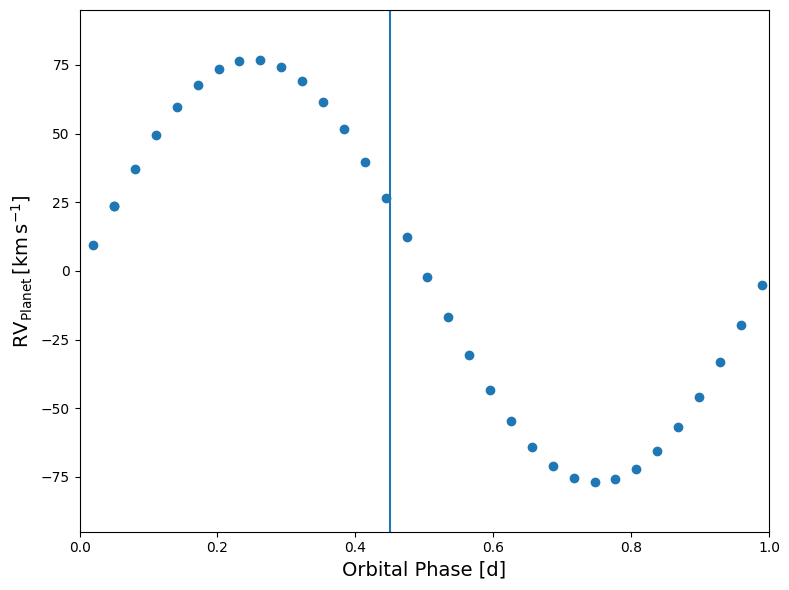

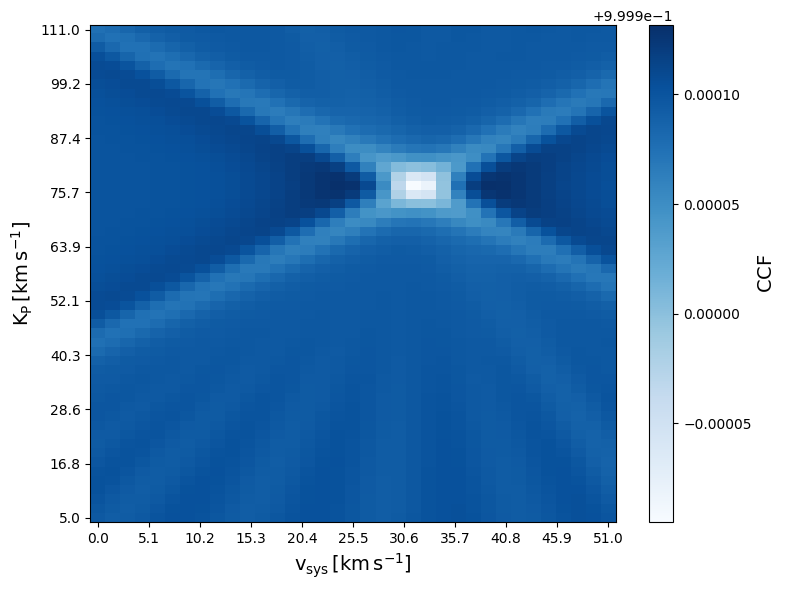

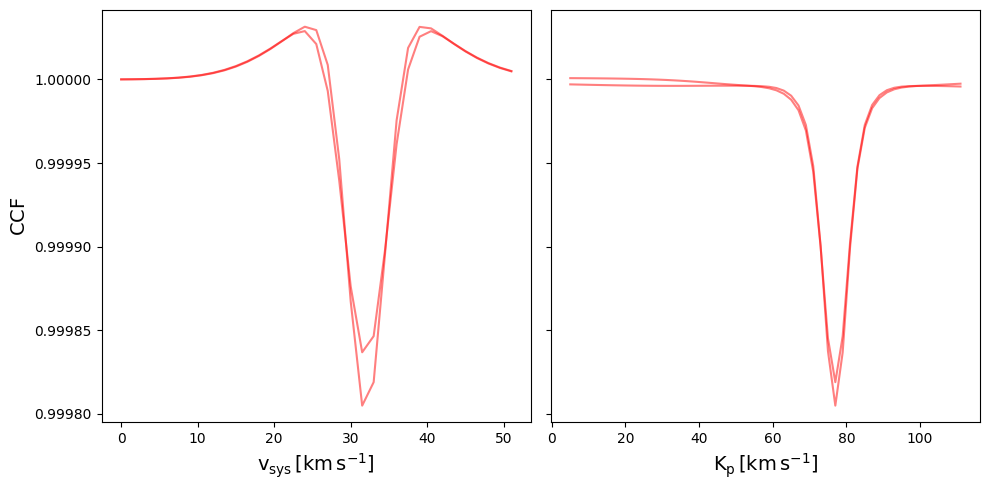

In [11]:
#Observing times of each datapoint used. 
obstimes = np.linspace(T0[0],T0[0]+period[0],34)
phases  = (obstimes-T_trans)%period[0]/period[0]

#Weighting. typically SNR of each observation 
weights = np.ones(len(obstimes))

planet=True #To fit the planet or the star. Ususally True, if it is the planet or secondary star (Note: The CCF map has to be specifically created for one case).
#pack parameters
obs = [obstimes,weights,planet]

# Visualise orbit
saltire.orbit_plot(obs,fixpar,K_start,T_trans=T_trans,T_occ=T_occ,
                   file=os.path.join(outp,'31_binary_orbit.png'),
                   save=True,plotting=True,ylim=(-95,95))

# Visualise model
model = saltire.fit_residual(params,x, y,obs=obs,fixpar=fixpar.T).reshape(len(K_p),len(velo))#,data=fit_data)
saltire.plot_axis2D(velo,K_p,model,savefig=True,outim=os.path.join(outp,'31_binary_model.png'))

# Plot cuts in both axes, lower and upper to the signal position. 
saltire.cutplot(velo,K_p,
                v_start,
                K_start,
                None,model,file=os.path.join(outp,'31_binary_cut.png'),save=True,plotting=True,margin=1e-5)

### 3.2) Arbritary sampled orbit

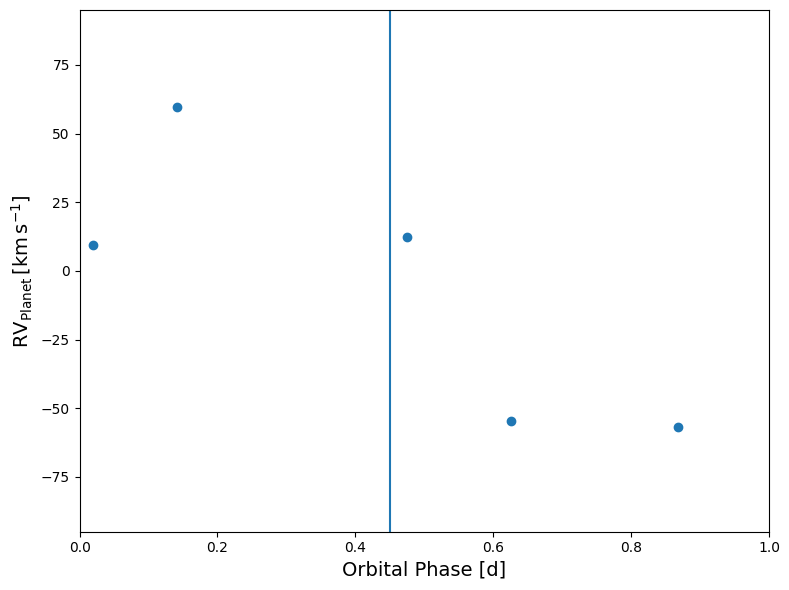

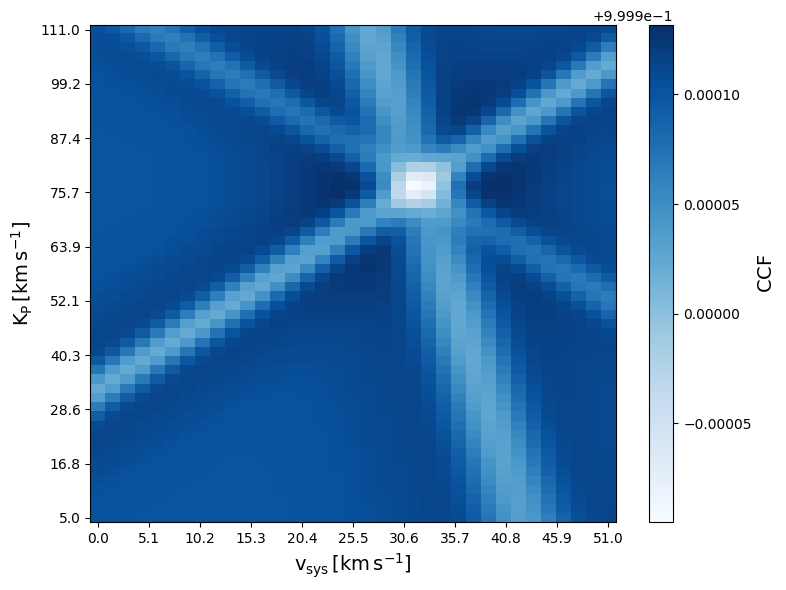

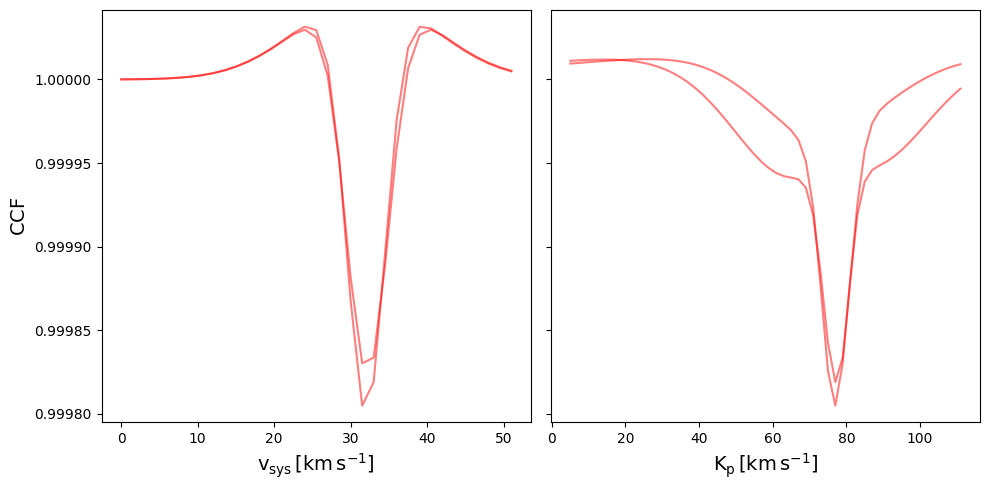

In [12]:
#Observing times of each datapoint used.
obstimes = np.linspace(T0[0],T0[0]+period[0],34)

#take 5 arbritary data points from above sample
np.random.seed(1)
obstimes = np.random.choice(obstimes, 5, replace=False)
'''
obstimes1 = T0[0]+0.1
obstimes2 = T0[0]+2
obstimes3 = T0[0]+2.1
obstimes4 = T0[0]+5
obstimes5 = T0[0]+5.2
obstimes=np.hstack([obstimes1,obstimes2,obstimes3,obstimes4,obstimes5])
'''
phases  = (obstimes-T_trans)%period[0]/period[0]

#Weighting. typically SNR of each observation 
weights = np.ones(len(obstimes))

planet=True #To fit the planet or the star. Ususally True, if it is the planet or secondary star (Note: The CCF map has to be specifically created for one case).
#pack parameters
obs = [obstimes,weights,planet]

# Visualise orbit
saltire.orbit_plot(obs,fixpar,K_start,T_trans=T_trans,T_occ=T_occ,
                   file=os.path.join(outp,'32_binary_orbit.png'),
                   save=True,plotting=True,ylim=(-95,95))

# Visualise model
model = saltire.fit_residual(params,x, y,obs=obs,fixpar=fixpar.T).reshape(len(K_p),len(velo))#,data=fit_data)
saltire.plot_axis2D(velo,K_p,model,savefig=True, outim=os.path.join(outp,'32_binary_model.png'))

# Plot cuts in both axes, lower and upper to the signal position.
saltire.cutplot(velo,K_p,
                v_start,
                K_start,
                None,model,file=os.path.join(outp,'32_binary_cut.png'),save=True,plotting=True,margin=1e-5)